In [25]:
import pyspark
from pyspark import SparkContext, SQLContext
from pyspark.sql import SparkSession 
from pyspark.sql.functions import split, regexp_replace,explode,translate,col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
# local
appName = "Genre_Analysis"
master = "local"

conf = pyspark.SparkConf()\
  .set('spark.driver.host','127.0.0.1')\
  .setAppName(appName)\
  .setMaster(master) 
  
sc = SparkContext.getOrCreate(conf=conf)

sqlContext = SQLContext(sc)

spark = SparkSession.builder.master("local[*]").appName(appName).getOrCreate()



In [9]:
# cloud
spark = SparkSession.builder.master("yarn").appName(appName).getOrCreate()

# Genre_analysis

In [32]:


df = spark.read.csv("data/movies_clean.csv", header=True, inferSchema=True)

# replace "['Action','Drama']" to "Action,Drama"
df = df.withColumn("Generes", regexp_replace(df["Generes"], "[\[\]']", ""))
df = df.withColumn("Generes", translate(df["Generes"], ", ", ","))

df.show()

+--------------------+------+-----------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+---------------+
|         movie title|Rating|User Rating|             Generes|            Overview|        Plot Kyeword|           Director|         Top 5 Casts|              Writer|           year|
+--------------------+------+-----------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+---------------+
|   Top Gun: Maverick|   8.6|   187000.0|        Action,Drama|After more than t...|['fighter jet', '...|    Joseph Kosinski|['Jack Epps Jr.',...|            Jim Cash|           2022|
|Jurassic World Do...|   6.0|    56000.0|Action,Adventure,...|Four years after ...|['dinosaur', 'jur...|    Colin Trevorrow|['Colin Trevorrow...|    Emily Carmichael|           2022|
|             Top Gun|   6.9|   380000.0|        Action,Drama|As students at th...|['

In [33]:
# explode Generes to a new column Genre
df = df.select(df['movie title'], explode(split(df['Generes'],",")).alias('Genre'))

df = df.groupBy(df['Genre']).count().orderBy('count', ascending=False)

top_genres = df.limit(10).toPandas()
top_genres


,Genre,count
0,Drama,12475
1,Action,7847
2,Comedy,6870
3,Crime,6050
4,Thriller,4974
5,Adventure,4454
6,Horror,3210
7,Romance,3157
8,Sci-Fi,2088
9,Mystery,2078


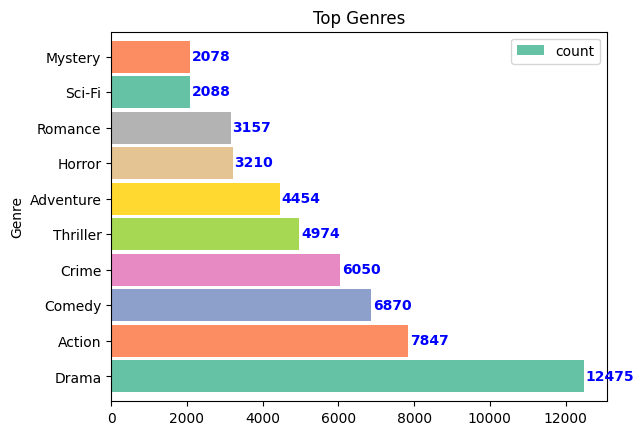

In [34]:
ax = top_genres.plot.barh(x='Genre', y='count',width=0.9, color=sns.color_palette('Set2',10))

for i, v in enumerate(top_genres['count']):
    ax.text(v + 50, i - 0.1, str(v), color='blue', fontweight='bold')

plt.title('Top Genres')
plt.show()

# Keywords Analysis

In [27]:
df = spark.read.csv("data/movies_clean.csv", header=True, inferSchema=True)

df = df.withColumn("Plot Kyeword", regexp_replace(df["Plot Kyeword"], "[\[\]']", ""))
df = df.withColumn("Plot Kyeword", translate(df["Plot Kyeword"], ", ", ","))
df = df.filter(col('Plot Kyeword') != '')

df.toPandas().head(3)

,movie title,Rating,User Rating,Generes,Overview,Plot Kyeword,Director,Top 5 Casts,Writer,year
0,Top Gun: Maverick,8.6,187000.0,"['Action', 'Drama']",After more than thirty years of service as one...,"fighterjet,sequel,u.s.navy,fighteraircraft,pil...",Joseph Kosinski,"['Jack Epps Jr.', 'Peter Craig', 'Tom Cruise',...",Jim Cash,2022
1,Jurassic World Dominion,6.0,56000.0,"['Action', 'Adventure', 'Sci-Fi']",Four years after the destruction of Isla Nubla...,"dinosaur,jurassicpark,tyrannosaurusrex,velocir...",Colin Trevorrow,"['Colin Trevorrow', 'Derek Connolly', 'Chris P...",Emily Carmichael,2022
2,Top Gun,6.9,380000.0,"['Action', 'Drama']",As students at the United States Navy's elite ...,"pilot,malecamaraderie,u.s.navy,grummanf14tomca...",Tony Scott,"['Jack Epps Jr.', 'Ehud Yonay', 'Tom Cruise', ...",Jim Cash,1986


In [28]:
# explode Generes to a new column Genre
df = df.select(df['movie title'], explode(split(df['Plot Kyeword'],",")).alias('Keywords'))

df = df.groupBy(df['Keywords']).count().orderBy('count', ascending=False)

top_genres = df.limit(10).toPandas()
top_genres

,Keywords,count
0,murder,1174
1,femalenudity,1102
2,psychotronicfilm,936
3,revenge,628
4,basedonnovel,622
5,sexscene,610
6,police,605
7,love,540
8,violence,516
9,barechestedmale,507


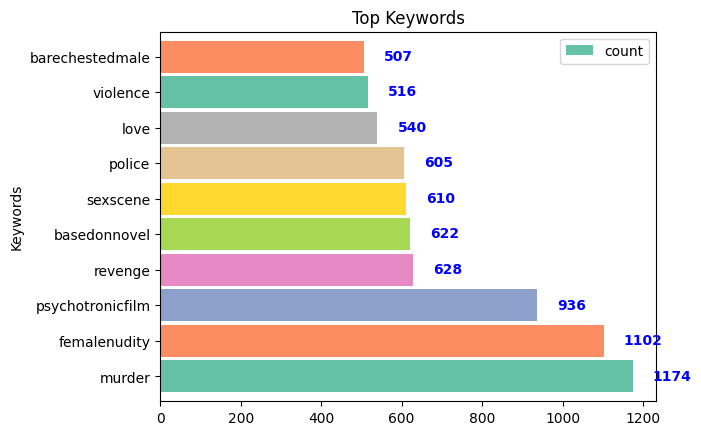

In [30]:
ax = top_genres.plot.barh(x='Keywords', y='count',width=0.9, color=sns.color_palette('Set2',10))

for i, v in enumerate(top_genres['count']):
    ax.text(v + 50, i - 0.1, str(v), color='blue', fontweight='bold')

plt.title('Top Keywords')
plt.show()